In [ ]:
%pip install pandas datasets sentence-transformers qdrant-client scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.7/306.7 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
from datasets import load_dataset

# Load Banking 77 dataset
banking77 = load_dataset("banking77")

# Convert to DataFrame
df_banking77 = pd.DataFrame({
    "query": banking77["train"]["text"],
    "intent": banking77["train"]["label"]
})

# Load intent names from dataset metadata
intent_names = banking77["train"].features["label"].names

# Replace numeric intent labels with actual intent names
df_banking77["intent"] = df_banking77["intent"].apply(lambda x: intent_names[x])

# Load the additional dataset (your generated dataset)
df_additional = pd.read_csv("/content/new_intents_queries.csv")

# Merge both datasets
df_combined = pd.concat([df_banking77, df_additional], ignore_index=True)
df_combined.head()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/14.4k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/298k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/93.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3080 [00:00<?, ? examples/s]

,query,intent
0,I am still waiting on my card?,card_arrival
1,What can I do if my card still hasn't arrived ...,card_arrival
2,I have been waiting over a week. Is the card s...,card_arrival
3,Can I track my card while it is in the process...,card_arrival
4,"How do I know if I will get my card, or if it ...",card_arrival


In [ ]:
from sklearn.model_selection import train_test_split

# Split additional dataset (same ratio as Banking 77)
df_train_add, df_test_add = train_test_split(df_additional, test_size=0.2, random_state=42)

# Load predefined train-test split of Banking 77
df_train_banking = pd.DataFrame({
    "query": banking77["train"]["text"],
    "intent": [intent_names[label] for label in banking77["train"]["label"]]
})

df_test_banking = pd.DataFrame({
    "query": banking77["test"]["text"],
    "intent": [intent_names[label] for label in banking77["test"]["label"]]
})

# Merge training and testing sets
df_train = pd.concat([df_train_banking, df_train_add], ignore_index=True)
df_test = pd.concat([df_test_banking, df_test_add], ignore_index=True)

print(f"Training size: {df_train.shape[0]}, Testing size: {df_test.shape[0]}")


Training size: 10838, Testing size: 3289


In [ ]:
from sentence_transformers import SentenceTransformer

# Load a pre-trained sentence transformer model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Generate embeddings
df_train["embedding"] = df_train["query"].apply(lambda x: model.encode(x, convert_to_tensor=True).tolist())
df_test["embedding"] = df_test["query"].apply(lambda x: model.encode(x, convert_to_tensor=True).tolist())


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams, PointStruct

# Connect to Qdrant (local or cloud)
client = QdrantClient(":memory:")  # Use ":memory:" for an in-memory DB

# Create a collection
client.recreate_collection(
    collection_name="banking_intents",
    vectors_config=VectorParams(size=len(df_train["embedding"][0]), distance=Distance.COSINE),
)

# Insert embeddings into Qdrant
points = [
    PointStruct(id=i, vector=df_train["embedding"][i], payload={"intent": df_train["intent"][i]})
    for i in range(len(df_train))
]
client.upsert(collection_name="banking_intents", points=points)


<ipython-input-5-5da15d6c5abd>:8: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

In [ ]:
import numpy as np

def search_intent(query):
    query_embedding = model.encode(query, convert_to_tensor=True).tolist()

    # Perform similarity search in Qdrant
    search_results = client.search(
        collection_name="banking_intents",
        query_vector=query_embedding,
        limit=1
    )

    return search_results[0].payload["intent"] if search_results else "No match found"

# Get user input
user_query = input("Enter your banking inquiry: ")

# Predict intent
predicted_intent = search_intent(user_query)
print(f"Predicted Intent: {predicted_intent}")

Enter your banking inquiry: How can I check blockchain transaction verification?
Predicted Intent: blockchain_transaction_verification


<ipython-input-6-532f4ccbf3ca>:7: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = client.search(


In [ ]:
from sklearn.metrics import classification_report

# Predict intents for test set
df_test["predicted_intent"] = df_test["query"].apply(search_intent)

# Compute classification report
print(classification_report(df_test["intent"], df_test["predicted_intent"]))


<ipython-input-6-532f4ccbf3ca>:7: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = client.search(


                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       0.97      0.93      0.95        40
                          account_closure_policy       1.00      1.00      1.00         4
                    account_reactivation_request       1.00      1.00      1.00         4
               account_upgrade_downgrade_options       1.00      1.00      1.00         2
                                activate_my_card       0.97      0.93      0.95        40
                                       age_limit       1.00      1.00      1.00        40
                         apple_pay_or_google_pay       0.98      1.00      0.99        40
                           atm_card_expiry_check       1.00      1.00      1.00         2
                           atm_pin_reset_request       1.00      1.00      1.00         3
                                     atm_support       0.97      0.97      0.97        40
         

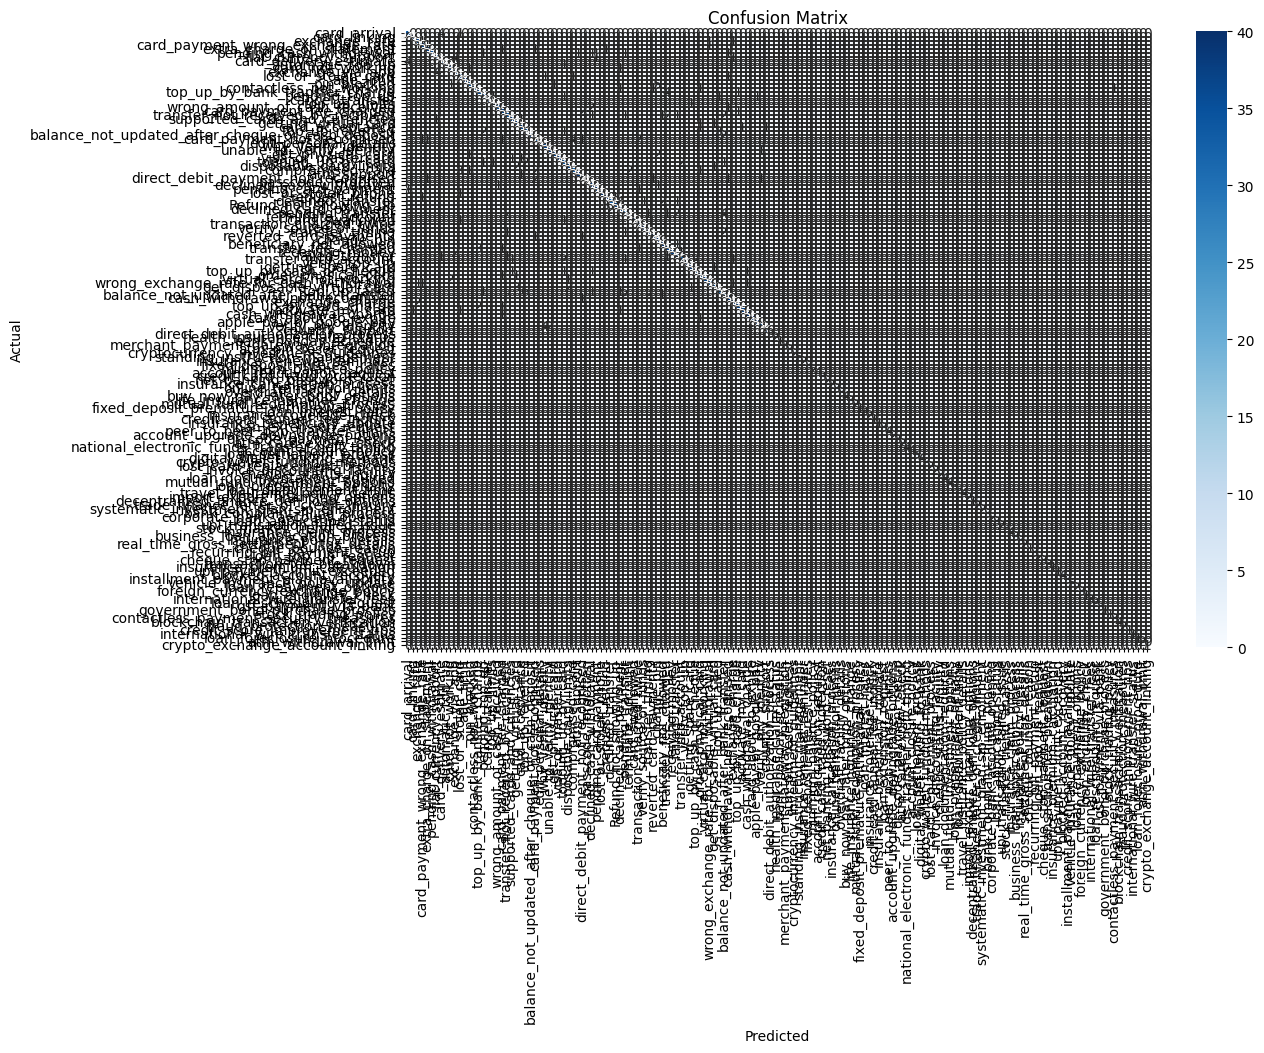

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(df_test["intent"], df_test["predicted_intent"], labels=df_test["intent"].unique())

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=df_test["intent"].unique(), yticklabels=df_test["intent"].unique())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


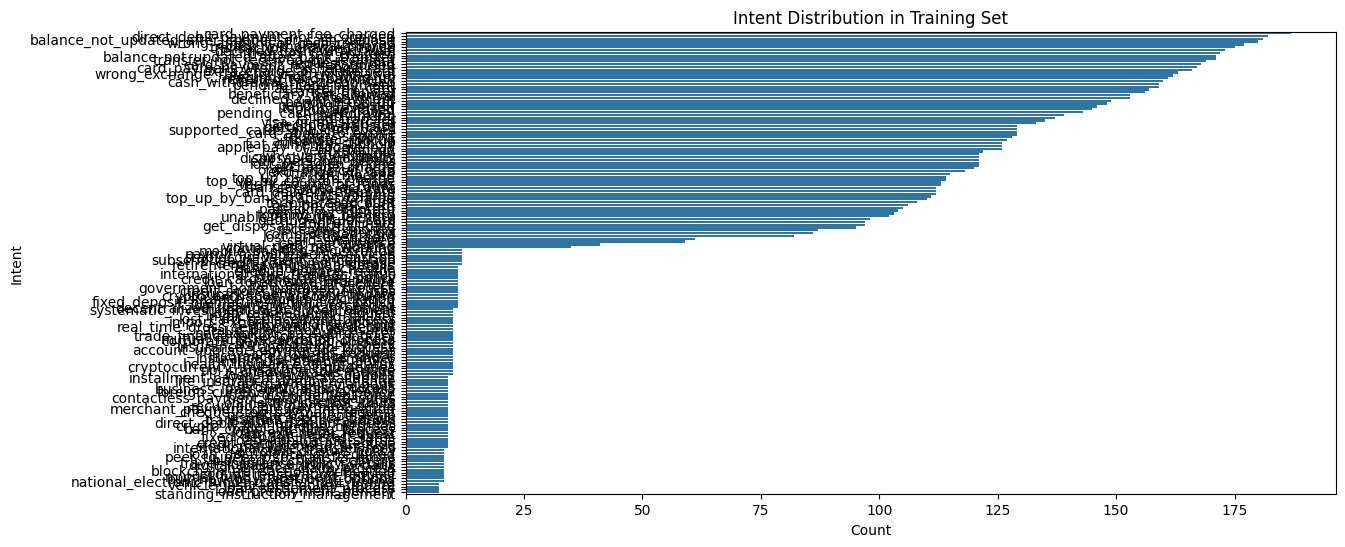

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(y=df_train["intent"], order=df_train["intent"].value_counts().index)
plt.xlabel("Count")
plt.ylabel("Intent")
plt.title("Intent Distribution in Training Set")
plt.show()


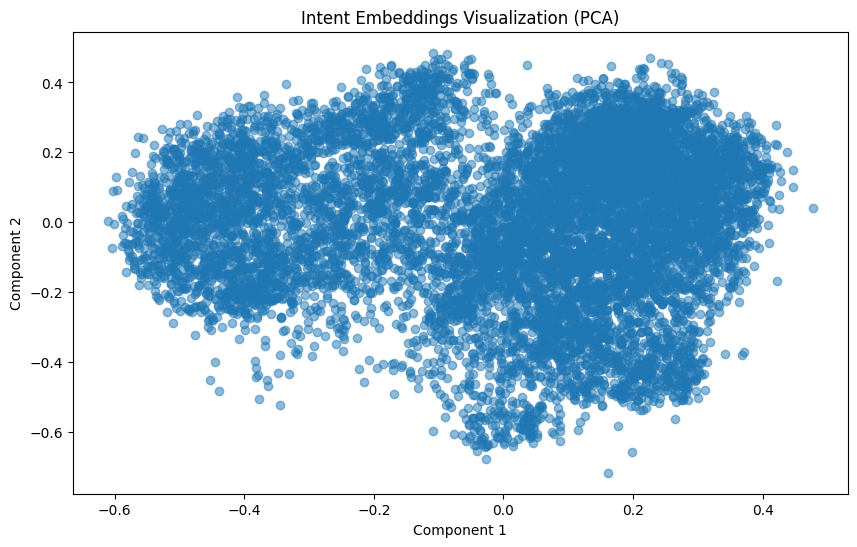

In [ ]:
from sklearn.decomposition import PCA

# Reduce dimensionality to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(np.array(df_train["embedding"].tolist()))

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.5)
plt.title("Intent Embeddings Visualization (PCA)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
accuracy = accuracy_score(df_test["intent"], df_test["predicted_intent"])
precision = precision_score(df_test["intent"], df_test["predicted_intent"], average="weighted")
recall = recall_score(df_test["intent"], df_test["predicted_intent"], average="weighted")
f1 = f1_score(df_test["intent"], df_test["predicted_intent"], average="weighted")

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Accuracy: 0.9252
Precision: 0.9267
Recall: 0.9252
F1-Score: 0.9251


In [ ]:
# Assuming 'df_train' or 'df_combined' contains your dataset

# Using 'df_train'
total_intents = len(df_train['intent'].unique())
print(f"Total number of intents: {total_intents}")

# Using 'df_combined'
total_intents = len(df_combined['intent'].unique())
print(f"Total number of intents: {total_intents}")

Total number of intents: 164
Total number of intents: 164
